<a href="https://colab.research.google.com/github/hydrogen1999/Public-file19/blob/main/Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
cd '/content/drive/MyDrive/Colab Notebooks/sensitive_data'

/content/drive/MyDrive/Colab Notebooks/sensitive_data


## **Library**

In [28]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences

import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM,
                          Embedding,
                          BatchNormalization,
                          Dense,
                          TimeDistributed,
                          Dropout,
                          Bidirectional,
                          Flatten,
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import nltk
nltk.download('punkt')
# from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

# logging.set_verbosity_error()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Defining Plot function**

In [29]:
import plotly.figure_factory as ff

x_axes = ['Non-spam', 'Spam']
y_axes =  ['Spam', 'Non-Spam']

def conf_matrix(z, x=x_axes, y=y_axes):

    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True

    return fig

In [30]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 5

## **Load data & Data preprocessing**

In [32]:
df = pd.read_csv("./data.csv")
print(df.spam.value_counts())

0    5687
1    1626
Name: spam, dtype: int64


In [33]:
# load stopwords vn
with open("./vietnamese.txt", 'r', encoding="utf8") as f:
    stop_words = [word[:-1] for word in f]
len(stop_words)

1943

In [34]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [35]:
df['comments_clean'] = df['comments'].apply(preprocess_data)
df

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,comments,spam,comments_clean
0,0,0,0.0,Hưởng Dương nha Việt Tân,1,hưởng dương nha việt tân
1,1,1,1.0,Hân hoan vĩnh biệt cụ. Vì cụ mà còn bị hành lê...,1,hân hoan vĩnh biệt cụ cụ hành hành nhục
2,2,2,2.0,Khi người ngu đi học thì chỉ có côpi mà thôi,1,ngu đi học côpi
3,3,3,3.0,"Tuy vậy, nhờ oai danh của cụ, biết bao anh em ...",0,oai danh cụ bao lãnh đạo chiến sỹ kiếm chác vô...
4,4,4,4.0,Hài hước đến thế là cùng. Cười đau bụng với cụ...,0,hài hước cười đau bụng cụ hộ khẩu giấy
...,...,...,...,...,...,...
7308,7308,4665,NaN,Ai có nhóm đào pi nào k ạ,0,đào pi k
7309,7309,4666,NaN,Cười vkl cái đồng coin vô giá trị,0,cười vkl đồng coin vô giá trị
7310,7310,4667,NaN,Đồng Đen,0,đồng đen
7311,7311,4668,NaN,Như này la sao vậy các ban,0,la ban


In [36]:
train_df, test_df = train_test_split(df, test_size=0.2)
print(train_df.spam.value_counts())
print(test_df.spam.value_counts())

0    4586
1    1264
Name: spam, dtype: int64
0    1101
1     362
Name: spam, dtype: int64


In [37]:

train_df = train_df.reset_index(drop=True)

skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.spam)):
    train_df.loc[val_, "kfold"] = fold
train_df

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,comments,spam,comments_clean,kfold
0,6618,3975,NaN,Chị em đỉnh quá,0,đỉnh,0.0
1,5695,3052,NaN,Rồi dự án tỷ đô gamefi đầu tiên của VN sẽ đi v...,0,dự án tỷ đô gamefi đầu tiên vn đi dĩ vãng 😩,0.0
2,1642,1642,1642.0,"thủy quân lục túi, lính thủy làm nail, binh đo...",1,thủy quân lục túi lính thủy nail binh đoàn huy...,0.0
3,2093,2093,2093.0,mấy thằng già nhìn như đầu c,1,mấy thằng già đầu c,0.0
4,2263,2263,4894.0,"per mất mặt thật sự , quán bún đậu đó không bi...",1,per mặt quán bún đậu dán mặt mày,0.0
...,...,...,...,...,...,...,...
5845,6171,3528,NaN,Nguyễn Thị Minh Phương,0,nguyễn thị minh phương,4.0
5846,1123,1123,1123.0,phục quốc chưa bác?,1,phục quốc,4.0
5847,3500,857,NaN,bạn tôi làm gì nhẹ nhàng nhớ bạn ơi . Cứ từ t...,0,nhẹ nhàng đừng nề 😓,4.0
5848,1888,1888,1888.0,Thứanhcầnlà Nụcườicủaem,0,thứanhcầnlà nụcườicủaem,4.0


In [38]:
x = df['comments_clean']
y = df['spam']

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5850 5850
1463 1463


## **Count Vector**

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
vect = CountVectorizer(ngram_range=(1,2))
vect.fit(train_df.comments_clean)

# Use the trained to create a document-term matrix from train and test sets
x_train_count = vect.transform(train_df.comments_clean)
x_test_count = vect.transform(test_df.comments_clean)

## **TF-IDF Word**

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_transformer = TfidfVectorizer(analyzer='word')

tfidf_transformer.fit(train_df.comments_clean)

x_train_tfidf_word = tfidf_transformer.transform(train_df.comments_clean)
x_test_tfidf_word =  tfidf_transformer.transform(test_df.comments_clean)

## **TF-IDF Ngram**

In [42]:
tfidf_transformer = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))

tfidf_transformer.fit(train_df.comments_clean)
x_train_tfidf_ngram = tfidf_transformer.transform(train_df.comments_clean)
x_test_tfidf_ngram =  tfidf_transformer.transform(test_df.comments_clean)

## **Count vector + TF-IDF**

In [43]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_count)
x_train_count_tfidf = tfidf_transformer.transform(x_train_count)
x_test_count_tfidf =  tfidf_transformer.transform(x_test_count)

## **Data for training**

In [44]:
X_train = [x_train_count, x_train_tfidf_word , x_train_tfidf_ngram, x_train_count_tfidf ]
X_test = [x_test_count, x_test_tfidf_word , x_test_tfidf_ngram, x_test_count_tfidf]

In [49]:
def train(X_train, X_test, model):
  for i in range(len(X_train)):
    model = model.fit(X_train[i], train_df.spam)
    acc_prediction  = model.predict(X_test[i])
    print(classification_report(test_df.spam, acc_prediction))
    print(confusion_matrix(test_df.spam, acc_prediction))

## **SVM**

In [50]:
cls = svm.SVC(C=10,kernel="rbf",gamma=0.1,)
train(X_train, X_test, cls)

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1101
           1       0.86      0.63      0.73       362

    accuracy                           0.88      1463
   macro avg       0.88      0.80      0.83      1463
weighted avg       0.88      0.88      0.88      1463

[[1065   36]
 [ 133  229]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1101
           1       0.85      0.69      0.77       362

    accuracy                           0.89      1463
   macro avg       0.88      0.83      0.85      1463
weighted avg       0.89      0.89      0.89      1463

[[1058   43]
 [ 111  251]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      1101
           1       0.83      0.68      0.75       362

    accuracy                           0.89      1463
   macro avg       0.87      0.82      0.84      1463
weighted avg       0

## **Random Forest**

In [63]:
from sklearn.ensemble import RandomForestClassifier

r_forest = RandomForestClassifier(n_estimators = 500)
train(X_train, X_test, r_forest)

ValueError: ignored

## **XGBOOST**

In [51]:
import xgboost as xgb
from sklearn import metrics
pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

In [52]:
pipe.fit(x_train, y_train)
y_pred_class = pipe.predict(x_test)
print(classification_report(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1131
           1       0.85      0.45      0.59       332

    accuracy                           0.86      1463
   macro avg       0.85      0.71      0.75      1463
weighted avg       0.86      0.86      0.84      1463



## **Glove + LSTM**

In [53]:
x = df['comments_clean']
y = df['spam']

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5850 5850
1463 1463


In [55]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

4563

In [56]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

In [57]:
longest_train = max(x_train, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
train_padded_sentences = pad_sequences(
    embed(x_train),
    length_long_sentence,
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(x_test),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[ 388, 2342,  323, ...,    0,    0,    0],
       [2343,   25,  168, ...,    0,    0,    0],
       [   5,  820,  749, ...,    0,    0,    0],
       ...,
       [ 238, 4562,    0, ...,    0,    0,    0],
       [ 216,  153, 2104, ...,    0,    0,    0],
       [ 154,   57, 2340, ...,    0,    0,    0]], dtype=int32)

In [58]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/content/drive/MyDrive/Colab Notebooks/sensitive_data/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [59]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.24928001, -0.48798001, -0.38414001, ..., -1.12940001,
        -0.65200001, -0.87127   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.14979994, -0.38624001,  0.040913  , ..., -0.73716003,
        -0.33379   , -0.23056   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(
    train_padded_sentences,
    y_train,
    test_size=0.25
)

In [61]:
def glove_lstm():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence
    ))

    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 139, 100)          456300    
                                                                 
 bidirectional (Bidirectiona  (None, 139, 278)         266880    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 278)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 278)              1112      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 278)               0         
                                                        

In [70]:
model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history_glove_lstm = model.fit(
    X_train,
    Y_train,
    epochs = 6,
    batch_size = 32,
    validation_data = (X_test, Y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/6
138/138 [==============================] - ETA: 0s - loss: 0.6091 - accuracy: 0.7440
Epoch 1: val_loss improved from inf to 0.63802, saving model to model.h5
138/138 [==============================] - 172s 1s/step - loss: 0.6091 - accuracy: 0.7440 - val_loss: 0.6380 - val_accuracy: 0.7977 - lr: 0.0010
Epoch 2/6
138/138 [==============================] - ETA: 0s - loss: 0.4820 - accuracy: 0.7905
Epoch 2: val_loss improved from 0.63802 to 0.47619, saving model to model.h5
138/138 [==============================] - 157s 1s/step - loss: 0.4820 - accuracy: 0.7905 - val_loss: 0.4762 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 3/6
138/138 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8402
Epoch 3: val_loss improved from 0.47619 to 0.35181, saving model to model.h5
138/138 [==============================] - 157s 1s/step - loss: 0.3746 - accuracy: 0.8402 - val_loss: 0.3518 - val_accuracy: 0.8305 - lr: 0.0010
Epoch 4/6
138/138 [==============================] - 

In [71]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

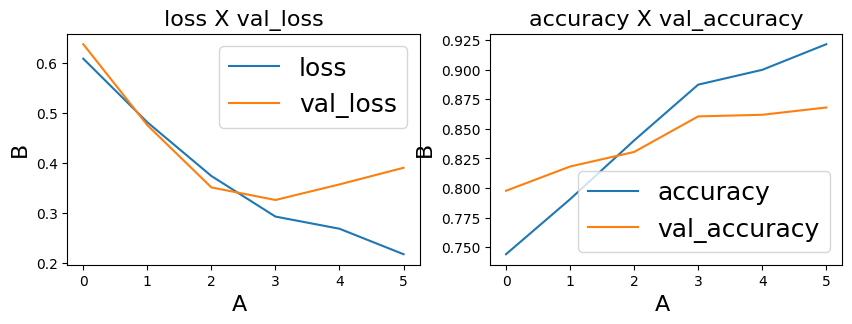

In [72]:

plot_learning_curves(history_glove_lstm, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

## **Word2Vec VN + LSTM**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from gensim.models import KeyedVectors


w2vModel = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/sensitive_data/baomoi.vn.model.bin', binary=True)

In [ ]:
x = df['comments_clean']
y = df['spam']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

5850 5850
1463 1463


In [ ]:
print("Vocabulary Length:", len(w2vModel.key_to_index))

Vocabulary Length: 439056


In [ ]:
input_length = 60
vocab_length = 450000
Embedding_dimensions = 300
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(x_train)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 450000


In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(x_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (5850, 60)
X_test.shape : (1463, 60)


In [ ]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if w2vModel.__contains__(word):
        embedding_matrix[token] = w2vModel.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (450000, 300)


In [ ]:
from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(300, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(300, dropout=0.3, return_sequences=True)),
        Conv1D(300, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [ ]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 300)           135000000 
                                                                 
 bidirectional_3 (Bidirectio  (None, 60, 600)          1442400   
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 60, 600)          2162400   
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 56, 300)           900300    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                   

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
6/6 [==============================] - 287s 35s/step - loss: 0.5625 - accuracy: 0.7096 - val_loss: 0.6013 - val_accuracy: 0.6718 - lr: 0.0010
Epoch 2/12
6/6 [==============================] - 217s 35s/step - loss: 0.4600 - accuracy: 0.7920 - val_loss: 0.3553 - val_accuracy: 0.8564 - lr: 0.0010
Epoch 3/12
6/6 [==============================] - 213s 35s/step - loss: 0.3597 - accuracy: 0.8562 - val_loss: 0.3636 - val_accuracy: 0.8581 - lr: 0.0010
Epoch 4/12
6/6 [==============================] - 210s 35s/step - loss: 0.3353 - accuracy: 0.8612 - val_loss: 0.3351 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 5/12
6/6 [==============================] - 213s 35s/step - loss: 0.3087 - accuracy: 0.8743 - val_loss: 0.3251 - val_accuracy: 0.8769 - lr: 0.0010
Epoch 6/12
6/6 [==============================] - 211s 34s/step - loss: 0.2891 - accuracy: 0.8858 - val_loss: 0.3165 - val_accuracy: 0.8718 - lr: 0.0010
Epoch 7/12
6/6 [==============================] - 214s 35s/step - loss: 0.2755 - a

##